In [1]:
import models
import os
import torch
from torch import optim, nn
from torchvision import transforms, datasets
import torchvision
import common
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#DIRECTORY SETTINGS
os.chdir("..")#Go up two directories
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'accuracy.pt')


#HYPERPARAMETERS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS=100
BATCH_SIZE = 512
criterion = nn.CrossEntropyLoss()
ADAM_OPTIMISER=True
LEARNING_RATE=0.001
WEIGHT_DECAY = 1e-6

In [3]:
train_transforms = transforms.Compose([# Data Transforms
                           transforms.Resize(256),#Resize
                           transforms.RandomHorizontalFlip(),#Flip
                           transforms.RandomRotation(10),#Roatate
                           transforms.RandomCrop(256, padding=4, padding_mode='reflect'),#Crop
                           transforms.ToTensor(),#Convert to Tensor
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#Normalize
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                       ])

In [4]:
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=train_transforms)#Use CIFAR10 to train
train_data, valid_data = torch.utils.data.random_split(train_data, [int(len(train_data)*0.9), len(train_data) - int(len(train_data)*0.9)])
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=test_transforms)


print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [5]:
model = torchvision.models.resnet18(pretrained=True)#TorchVision

for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model = nn.DataParallel(model)

#Hyperparameters
if(ADAM_OPTIMISER):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
else:
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

0
| Epoch: 01 | Train Loss: 1.527 | Train Acc: 53.14% | Val. Loss: 1.078 | Val. Acc: 67.03% |
1
| Epoch: 02 | Train Loss: 0.981 | Train Acc: 70.11% | Val. Loss: 0.899 | Val. Acc: 71.26% |
2
| Epoch: 03 | Train Loss: 0.866 | Train Acc: 72.45% | Val. Loss: 0.821 | Val. Acc: 73.17% |
3
| Epoch: 04 | Train Loss: 0.807 | Train Acc: 73.92% | Val. Loss: 0.787 | Val. Acc: 73.61% |
4
| Epoch: 05 | Train Loss: 0.781 | Train Acc: 74.28% | Val. Loss: 0.755 | Val. Acc: 74.18% |
5
| Epoch: 06 | Train Loss: 0.756 | Train Acc: 74.89% | Val. Loss: 0.755 | Val. Acc: 74.64% |
6
| Epoch: 07 | Train Loss: 0.740 | Train Acc: 75.52% | Val. Loss: 0.723 | Val. Acc: 75.56% |
7
| Epoch: 08 | Train Loss: 0.734 | Train Acc: 75.40% | Val. Loss: 0.722 | Val. Acc: 75.35% |
8
| Epoch: 09 | Train Loss: 0.722 | Train Acc: 75.71% | Val. Loss: 0.720 | Val. Acc: 75.24% |
9
| Epoch: 10 | Train Loss: 0.715 | Train Acc: 76.02% | Val. Loss: 0.706 | Val. Acc: 76.43% |
10
| Epoch: 11 | Train Loss: 0.712 | Train Acc: 75.92% | Val

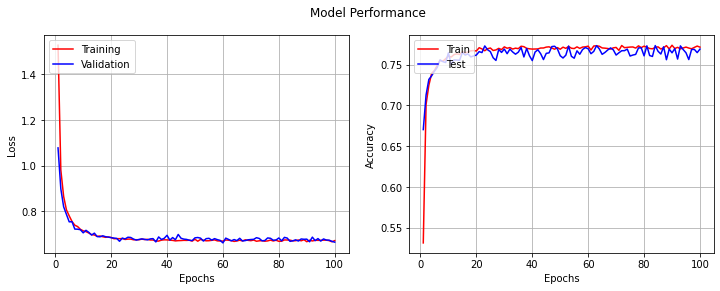

In [6]:
#Train
best_valid_loss = float('inf')
epoch_hist = [] # List to store epochs
train_loss_hist = [] # List to store training loss
train_acc_hist = [] # List to store training accuracy
valid_loss_hist = [] # List to store validation loss
valid_acc_hist = [] # List to store validation accuracy
for epoch in range(EPOCHS):#Range of Epochs
    print(epoch)
    train_loss, train_acc = common.train(model, device, train_iterator, optimizer, criterion)#Train Loss Calculation
    scheduler.step()
    valid_loss, valid_acc = common.evaluate(model, device, valid_iterator, criterion)#Validation Loss Calculation
    epoch_hist.append(epoch+1) # Append epoch
    train_loss_hist.append(train_loss) # Append training loss
    train_acc_hist.append(train_acc) # Append training accuracy
    valid_loss_hist.append(valid_loss) # Append validation loss
    valid_acc_hist.append(valid_acc) # Append validation accuracy

    if valid_loss < best_valid_loss:#Validation Loss - Is current lower than the saved validation loss.
        best_valid_loss = valid_loss#Save the best loss (lowest)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)#Save the model

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

# Plot loss and accuracy plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) # Create side-by-side subplots
fig.suptitle('Model Performance') # Common plot title
# Plot loss curves
ax1.plot(epoch_hist, train_loss_hist, label='Training', color='red') # Plot training loss
ax1.plot(epoch_hist, valid_loss_hist, label='Validation', color='blue') # Plot validation loss
ax1.legend(loc='upper left') # Show legend
ax1.set_xlabel('Epochs') # Show label for X-axis
ax1.set_ylabel('Loss') # Show label for Y-axis
ax1.grid(True) # Show grid
# Plot accuracy curves
ax2.plot(epoch_hist, train_acc_hist, label='Train', color='red') # Plot training accuracy
ax2.plot(epoch_hist, valid_acc_hist, label='Test', color='blue') # Plot validation accuracy
ax2.legend(loc='upper left') # Show legend
ax2.set_xlabel('Epochs') # Show label for X-axis
ax2.set_ylabel('Accuracy') # Show label for Y-axis
ax2.grid(True) # Show grid

In [7]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH)) #Load best weights from file
test_loss, test_acc = common.evaluate(model, device, valid_iterator, criterion) #Test Loss is dependent on
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}%')

| Test Loss: 0.674 | Test Acc: 76.68%


Files already downloaded and verified


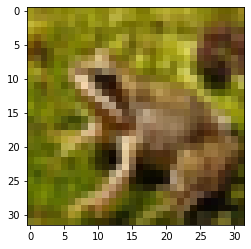

Ground Truth:  frog
Predicted:  frog


In [33]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Class labels

def imshow(img):
    img = img*0.5 +0.5 # Unnormalize
    npimg = img.numpy() # Convert tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose
    plt.show() # Show

# Get a random test image
test_img_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                       ])
test_img = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=test_img_transform)
test_img_iterator = torch.utils.data.DataLoader(test_img, shuffle=True, batch_size=1)
dataiter = iter(test_img_iterator)
image, label = next(dataiter)

# Show image and labes (GT vs. prediction)
imshow(torchvision.utils.make_grid(image))
print('Ground Truth: ',classes[label])
outputs = model(image)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', classes[predicted])